# 🚴‍♀️ Bysykkel and Topography: Analyzing Oslo's Urban Bike Patterns
This project explores how Oslo's elevation influences bike-sharing usage using data from the entire year. We enrich station data with elevation, calculate elevation differences and gradients per trip, and analyze usage trends.  
  
Data source: https://oslobysykkel.no/apne-data/historisk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import duckdb
import glob
import requests
import os
from haversine import haversine, Unit
from datetime import datetime as dt
import seaborn as sns

## 📥 Step 1 – Load Raw Trip Data into DuckDB

This step reads all monthly CSV files from the `../data/` folder and loads them into a DuckDB database file (`bysykkel_2024.duckdb`). If the database doesn't exist, it will be created. 

In [2]:
# Load all CSVs into DuckDB table 'trips_raw'
con = duckdb.connect("../bysykkel_2024.duckdb")

csv_files = glob.glob("../data/??.csv")
for i, file in enumerate(csv_files):
    if i == 0:
        con.execute(f"CREATE OR REPLACE TABLE trips_raw AS SELECT * FROM read_csv_auto('{file}')")
    else:
        con.execute(f"INSERT INTO trips_raw SELECT * FROM read_csv_auto('{file}')")

con.execute("CHECKPOINT")
print("Loaded trips_raw data into DuckDB")

Loaded trips_raw data into DuckDB


## Step 1.1 - Clean the dataset, explore columns

In [3]:
trips = con.execute('SELECT * FROM trips_raw').df()
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143379 entries, 0 to 1143378
Data columns (total 13 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   started_at                 1143379 non-null  datetime64[ns]
 1   ended_at                   1143379 non-null  datetime64[ns]
 2   duration                   1143379 non-null  int64         
 3   start_station_id           1143379 non-null  int64         
 4   start_station_name         1143379 non-null  object        
 5   start_station_description  1143374 non-null  object        
 6   start_station_latitude     1143379 non-null  float64       
 7   start_station_longitude    1143379 non-null  float64       
 8   end_station_id             1143379 non-null  int64         
 9   end_station_name           1143379 non-null  object        
 10  end_station_description    1143374 non-null  object        
 11  end_station_latitude       1143379 no

There are no nan values, only in station descriptions. Remove the station descriptions. 

In [4]:
trips = trips.drop(['start_station_description', 'end_station_description'], axis=1, errors='ignore')

##### 1.1.1 Duration

(0.0, 60.0)

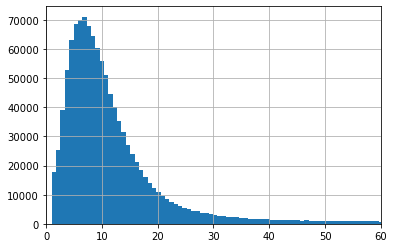

In [5]:
(trips['duration']/60).hist(bins=600)
plt.xlim([0, 60])

In [6]:
trips['duration'].describe()

count    1.143379e+06
mean     7.668218e+02
std      8.511188e+02
min      6.100000e+01
25%      3.550000e+02
50%      5.530000e+02
75%      8.560000e+02
max      2.817300e+04
Name: duration, dtype: float64

In [7]:
# Remove trips that are longer than 2 hours 
trips = trips[trips['duration']<=7200]

##### 1.1.2 started_at


In [8]:
# Check if ended_at is always after started_at
(trips['ended_at'] >= trips['started_at']).all()

True

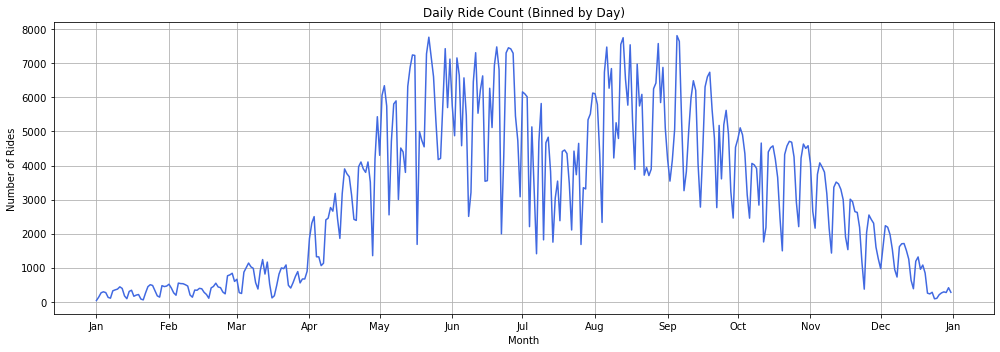

In [9]:
import matplotlib.dates as mdates

# Group by day
daily = trips.groupby(trips['started_at'].dt.date).size()

# Convert index to datetime (from date)
daily.index = pd.to_datetime(daily.index)

# Plot
plt.figure(figsize=(14, 5))
plt.plot(daily.index, daily.values, color='royalblue')

# Format x-axis with months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title("Daily Ride Count (Binned by Day)")
plt.xlabel("Month")
plt.ylabel("Number of Rides")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Investigate loops

In [10]:
df_loops = trips[trips['start_station_id']==trips['end_station_id']]
len(df_loops)

29694

(0.0, 5.0)

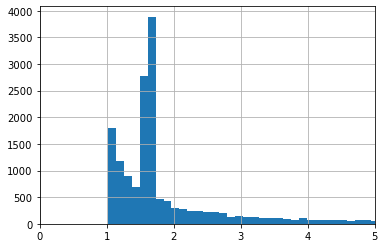

In [11]:
(df_loops['duration']/60).hist(bins=1000)
plt.xlim([0, 5])

I want to investigate topology. Do loops even matter here? No. They don’t carry slope info. I will remove the useless ones and tag the rest.  
  
  Trips that started and ended at the same station with a duration under 3 minutes were removed, as they likely represent cancelled or test rides. Remaining loops were tagged as is_loop but excluded from slope-based analysis, as their paths and elevation data cannot be meaningfully inferred.

In [12]:
# Drop short loops under 3 minutes
trips = trips[~((trips['start_station_id'] == trips['end_station_id']) & (trips['duration'] < 180))]

# Tag remaining loops
trips.loc[:,'is_loop'] = trips['start_station_id'] == trips['end_station_id']

/Users/harald/opt/anaconda3/envs/pythom/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


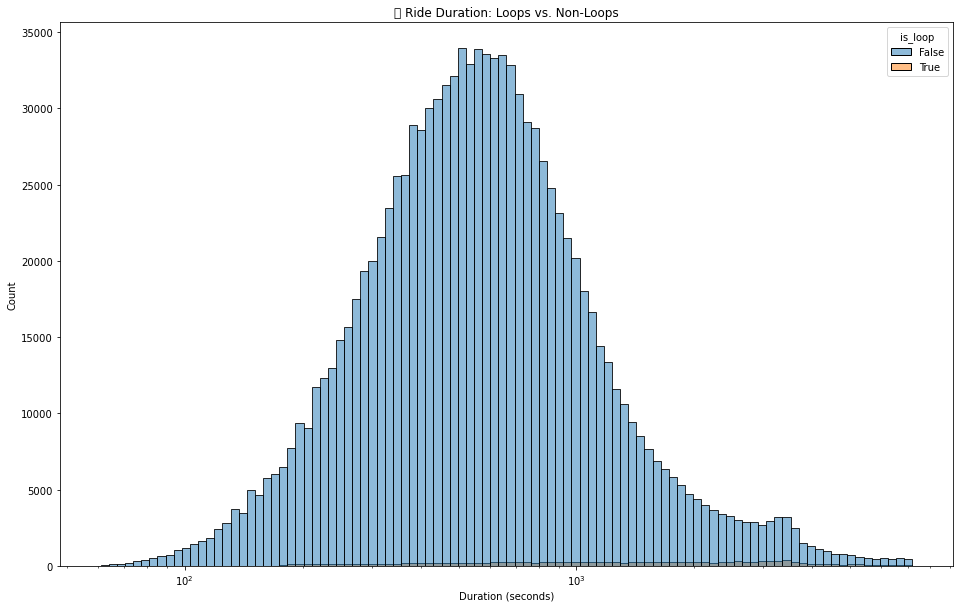

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot duration distribution, log scale helps
plt.figure(figsize=(16,10))
sns.histplot(data=trips, x='duration', hue='is_loop', bins=100, log_scale=True)
plt.title("🕒 Ride Duration: Loops vs. Non-Loops")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

In [14]:
# Save cleaned and tagged trips back to DuckDB
con.register("cleaned_df", trips)
con.execute("CREATE OR REPLACE TABLE trips_v1_cleaned AS SELECT * FROM cleaned_df")
con.unregister("cleaned_df")
con.execute("CHECKPOINT")
print("✅ Cleaned trips saved to DuckDB as 'trips_v1_cleaned'")

✅ Cleaned trips saved to DuckDB as 'trips_v1_cleaned'


## 🧱 Step 2 – Extract Unique Stations

We build a `stations` table by combining all distinct start and end stations from the `trips_cleaned` table. This gives us the full list of physical bike stations to enrich with elevation later.

In [15]:
con.execute("""
CREATE OR REPLACE TABLE stations AS
SELECT DISTINCT
    station_id,
    station_name,
    lat,
    lon
FROM (
    SELECT
        start_station_id AS station_id,
        start_station_name AS station_name,
        start_station_latitude AS lat,
        start_station_longitude AS lon
    FROM trips_v1_cleaned

    UNION

    SELECT
        end_station_id AS station_id,
        end_station_name AS station_name,
        end_station_latitude AS lat,
        end_station_longitude AS lon
    FROM trips_v1_cleaned
)
ORDER BY station_id
""")

con.execute("CHECKPOINT")
print("Extracted and saved stations table")

Extracted and saved stations table


## Step 3 - Using open-elevation api to populate the stations table with elevation data.

In [16]:
csv_path = "../data/stations_with_elevation.csv"

def get_elevation(row):
    lat = row['lat']
    lon = row['lon']
    
    response = requests.get(f"https://api.open-meteo.com/v1/elevation?latitude={lat}&longitude={lon}")
    data = response.json()
    return data['elevation'][0]

if os.path.exists(csv_path):
    print("Found existing data. Loading from csv.")
    stations = pd.read_csv(csv_path)
else:
    print("No csv found. Fetching elevation data from API.")
    stations = con.execute("SELECT * FROM stations").df()
    stations['elevation'] = stations.apply(get_elevation, axis=1)
    stations.to_csv("../data/stations_with_elevation.csv", index=False)

print("Elevation received for all stations.")

Found existing data. Loading from csv.
Elevation received for all stations.


In [17]:
# Save elevation data to database
con.register("stations_df", stations)
con.execute("CREATE OR REPLACE TABLE stations AS SELECT * FROM stations_df")
con.unregister("stations_df")

In [18]:
con.execute("""
CREATE OR REPLACE TABLE trips_v2_elevation AS
SELECT
    t.*,   
    s_start.elevation AS start_elevation,
    s_end.elevation AS end_elevation,
    s_end.elevation - s_start.elevation AS elevation_diff
FROM trips_v1_cleaned t
JOIN stations s_start ON t.start_station_id = s_start.station_id
JOIN stations s_end ON t.end_station_id = s_end.station_id
""")

con.execute("CHECKPOINT")

In [19]:
con.execute("SHOW TABLES").df()
trips = con.execute("SELECT * FROM trips_v2_elevation").df()

<AxesSubplot:>

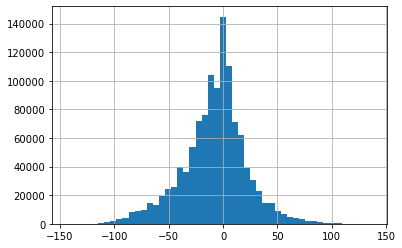

In [20]:
trips['elevation_diff'].hist(bins=50)

In [21]:
trips['elevation_diff'].median()

-5.0

In [22]:
trips['elevation_diff'].skew()

-0.2114508288231728

## Step 4 - Compute travel distance and gradient

In [23]:
df_stage = con.execute("SELECT * FROM trips_v2_elevation").df()

def compute_distance(row):
    start = (row['start_station_latitude'], row['start_station_longitude'])
    end = (row['end_station_latitude'], row['end_station_longitude'])
    return haversine(start, end, unit=Unit.METERS)

df_stage["distance"] = df_stage.apply(compute_distance, axis=1)

def compute_gradient(row):
    if row['distance'] == 0:
        return np.nan
    return row['elevation_diff'] / row['distance'] * 100

df_stage["gradient"] = df_stage.apply(compute_gradient, axis=1)

# Update table with final fields
con.register("stage_df", df_stage)
con.execute("CREATE OR REPLACE TABLE trips_v3_gradient AS SELECT * FROM stage_df")
con.unregister("stage_df")
con.execute("CHECKPOINT")

In [24]:
con.execute("SHOW TABLES").df()

,name
0,stations
1,trips_raw
2,trips_v1_cleaned
3,trips_v2_elevation
4,trips_v3_gradient
5,trips_v4_slope


In [25]:
trips = con.execute("FROM trips_v3_gradient SELECT *").df()
trips.head(2)

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,is_loop,start_elevation,end_elevation,elevation_diff,distance,gradient
0,2024-08-22 06:36:08.379,2024-08-22 06:45:32.332,563,551,Olaf Ryes plass,59.922425,10.758182,392,Sjøsiden 2 ved fontenen,59.910181,10.751699,False,25.0,12.0,-13.0,1408.629235,-0.922883
1,2024-08-22 06:36:15.407,2024-08-22 06:46:06.429,591,399,Uelands gate,59.929545,10.748986,571,Over Rådhusgata,59.910121,10.740713,False,48.0,19.0,-29.0,2208.554625,-1.313076


In [26]:
trips["gradient"].median()

-0.48555548293528855

(-10.0, 10.0)

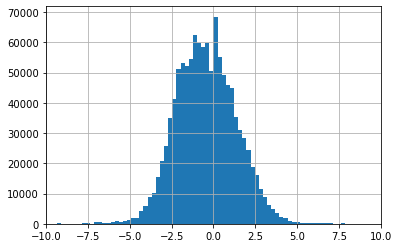

In [27]:
trips["gradient"].hist(bins=200)
plt.xlim([-10, 10])

In [28]:
# Ich glaube sehr viele Leute fahren einfach am Meer entlang. Das ist sicher der Peak bei 0. wenn man den entfernt, dann sieht man vielleicht wie "skewed" es ist. Was ist wenn du die beliebtesten Routen ausfindig machst. Verusche ein Muster herauszufinen. 

In [29]:
trips['gradient'].skew()

0.10501647634032081

In [30]:
n_downhill = trips['gradient'][trips['gradient']<0].size
n_uphill = trips['gradient'][trips['gradient']>0].size
total_rides = trips['gradient'].size

net_bias = (n_downhill - n_uphill) / total_rides * 100
relative_increase = (n_downhill - n_uphill) / n_uphill * 100

print(f"Out of all rides, {net_bias:.0f}% more go downhill than uphill.")
print(f"When comparing only uphill and downhill rides, downhill trips are {relative_increase:.0f}% more common than uphill ones.")

Out of all rides, 20% more go downhill than uphill.
When comparing only uphill and downhill rides, downhill trips are 53% more common than uphill ones.


- Computed elevation differece has a skew of -0.22 (mildy downhill-biased)
- Elevation difference alone is misleading -> compute gradient
- Found gradient skew is +0.10, but visually looks more negatively biased
- Noticed a spike around 0-small positive gradient -> suspect: flat seaside rides
- Have a sense that total ride time might be a more honest metric than ride count

## Step 5 - Use ride duration and total distance ridden as new metric
Ride count can be misleading.  
  
Trying these alternate targets:  
    - Total ride duration  
    - Total distance ridden  

Will do this for downhill vs uphill. 

In [31]:
# Create a slope type
con.execute("""
CREATE OR REPLACE TABLE trips_v4_slope AS
SELECT *,
    CASE
        WHEN gradient IS NULL THEN 'unknown'
        WHEN gradient < 0 THEN 'downhill'
        WHEN gradient > 0 THEN 'uphill'
        ELSE 'flat'
    END AS slope_type
FROM trips_v3_gradient
"""
)

In [32]:
con.execute("SHOW TABLES").df()

,name
0,stations
1,trips_raw
2,trips_v1_cleaned
3,trips_v2_elevation
4,trips_v3_gradient
5,trips_v4_slope


Text(0, 0.5, 'Number of Trips')

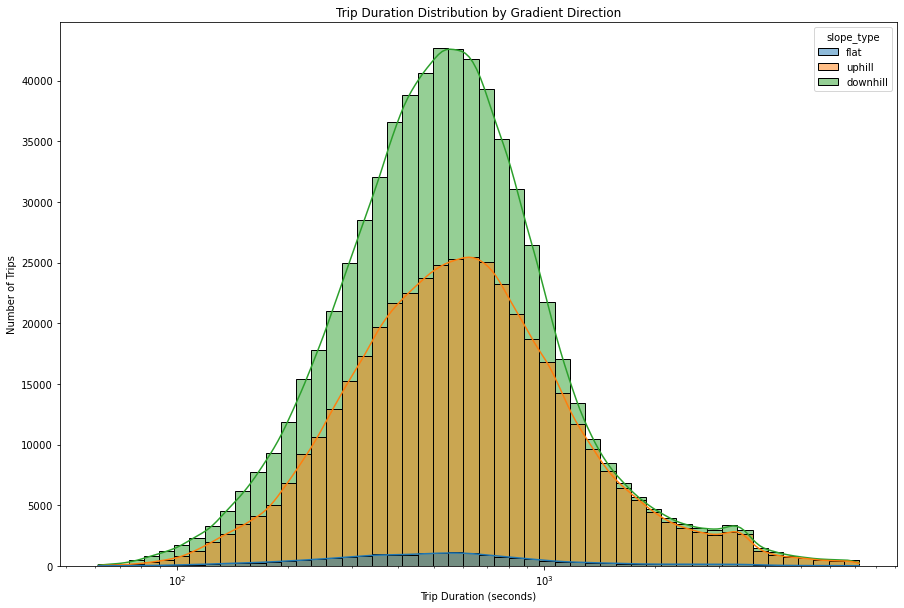

In [33]:
# Histogram of Trip Duration, split by gradient sign

trips = con.execute("SELECT * FROM trips_v4_slope").df()
trips = trips[~trips['is_loop']]

# Plot histogram
plt.figure(figsize=(15,10))
sns.histplot(data=trips, x='duration', hue='slope_type', hue_order=['flat', 'uphill', 'downhill'], bins=50, kde=True, log_scale=True)
plt.title("Trip Duration Distribution by Gradient Direction")
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Number of Trips")

Text(0, 0.5, 'Number of Trips')

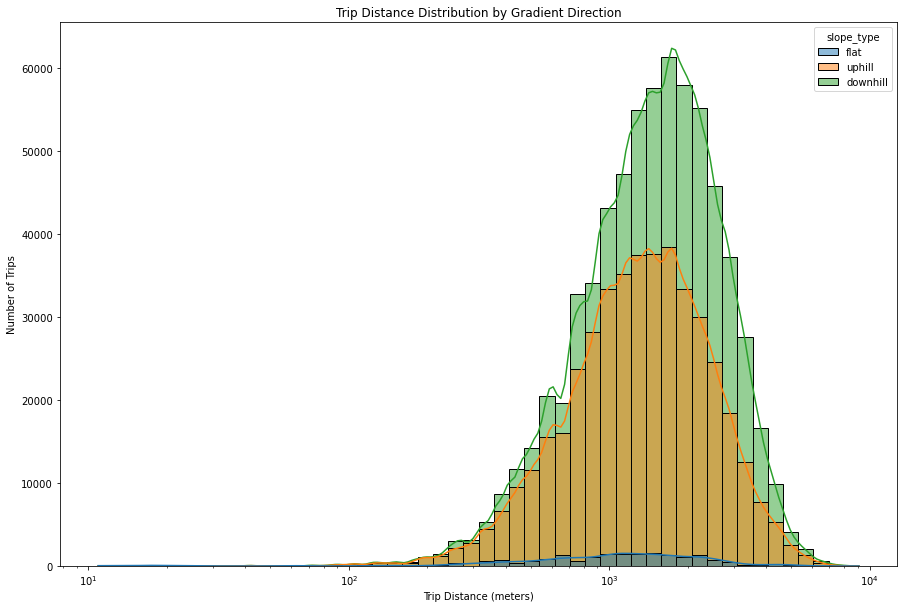

In [34]:
# Histogram of Trip Distance, split by gradient sign

# Plot histogram
plt.figure(figsize=(15,10))
sns.histplot(data=trips, x='distance', hue='slope_type', hue_order=['flat', 'uphill', 'downhill'], bins=50, kde=True, log_scale=True)
plt.title("Trip Distance Distribution by Gradient Direction")
plt.xlabel("Trip Distance (meters)")
plt.ylabel("Number of Trips")

In [35]:
summary = trips.groupby('slope_type').agg({
    'duration': 'sum',
    'distance': 'sum',
    'gradient': 'mean'
})
print(summary)

             duration      distance  gradient
slope_type                                   
downhill    476442627  1.146551e+09 -1.606735
flat         13849925  2.452180e+07  0.000000
uphill      346314470  6.825308e+08  1.328072


In [41]:
# Extract values
duration_down = summary.loc['downhill', 'duration']
duration_up = summary.loc['uphill', 'duration']
distance_down = summary.loc['downhill', 'distance']
distance_up = summary.loc['uphill', 'distance']

# Relative increase (compared to uphill)
duration_diff_pct = (duration_down - duration_up) / duration_up * 100
distance_diff_pct = (distance_down - distance_up) / distance_up * 100

# Net share difference (relative to total)
duration_total = duration_down + duration_up
distance_total = distance_down + distance_up

duration_net_share = (duration_down - duration_up) / duration_total * 100
distance_net_share = (distance_down - distance_up) / distance_total * 100

# Print it like you mean it
print(f"Duration:")
print(f"• Downhill trips took {duration_diff_pct:.1f}% more total ride time than uphill trips.")
print(f"• Net share: {duration_net_share:.1f}% more ride time downhill than uphill.\n")

print(f"Distance:")
print(f"• Downhill trips covered {distance_diff_pct:.1f}% more total distance than uphill trips.")
print(f"• Net share: {distance_net_share:.1f}% more distance ridden downhill than uphill.")

Duration:
• Downhill trips took 37.6% more total ride time than uphill trips.
• Net share: 15.8% more ride time downhill than uphill.

Distance:
• Downhill trips covered 68.0% more total distance than uphill trips.
• Net share: 25.4% more distance ridden downhill than uphill.


In [42]:
# Average duration and distance per ride, grouped by slope
avg_summary = trips.groupby('slope_type').agg({
    'duration': ['mean', 'count'],
    'distance': 'mean'
})

avg_summary.columns = ['avg_duration', 'ride_count', 'avg_distance']
avg_summary = avg_summary.reset_index()

print("Average Ride Metrics by Slope Type:\n")
print(avg_summary.to_string(index=False))

# Fancy sentence version:
for _, row in avg_summary.iterrows():
    slope = row['slope_type']
    print(f"• {slope.capitalize()} rides: average duration = {row['avg_duration']:.1f} seconds, "
          f"average distance = {row['avg_distance']:.1f} meters "
          f"({int(row['ride_count'])} rides)")

Average Ride Metrics by Slope Type:

slope_type  avg_duration  ride_count  avg_distance
  downhill    701.969179      678723   1689.276382
      flat    742.862315       18644   1315.265217
    uphill    782.521929      442562   1542.226465
• Downhill rides: average duration = 702.0 seconds, average distance = 1689.3 meters (678723 rides)
• Flat rides: average duration = 742.9 seconds, average distance = 1315.3 meters (18644 rides)
• Uphill rides: average duration = 782.5 seconds, average distance = 1542.2 meters (442562 rides)


On average, uphill rides are 11% longer in time, despite covering ~9% less distance than downhill rides. This suggests that uphill rides are not only fewer, but also slower—consistent with the physical challenge of biking uphill. Downhill rides, on the other hand, are both more common and slightly longer in distance, indicating that gravity is a strong motivator for mobility behavior in Oslo.

Interpretation  
	•	More trips go downhill than uphill  
	•	Downhill trips take more time in total, even though each is typically shorter, suggesting they’re more common  
	•	Uphill trips are longer per ride, because it takes more effort  
	•	This confirms that elevation influences mobility patterns  

## Step 6 - Group and Tag Stations: Spatial Intelligence

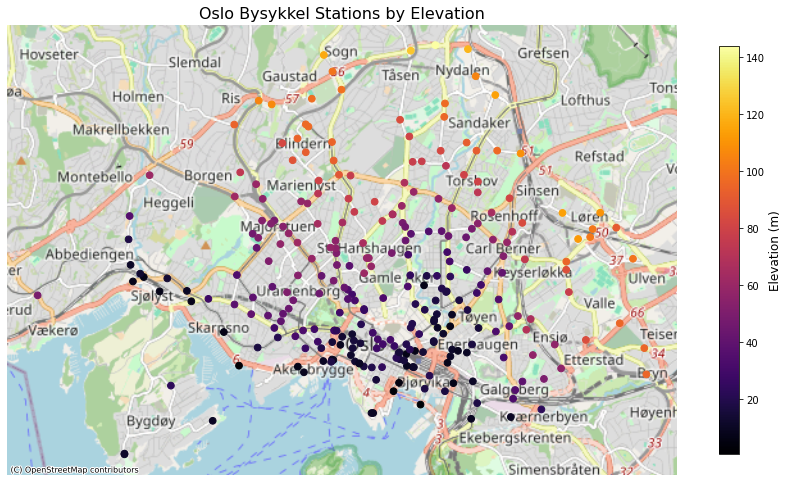

In [43]:
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Convert your stations DataFrame into a GeoDataFrame
stations['geometry'] = stations.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf = gpd.GeoDataFrame(stations, geometry='geometry', crs='EPSG:4326')
gdf = gdf.to_crs(epsg=3857)  # for compatibility with basemap tiles

# Choose a clear, dramatic colormap
cmap = cm.inferno  # Or plasma, magma, viridis

# Set up normalization for elevation color scale
norm = Normalize(vmin=gdf['elevation'].min(), vmax=gdf['elevation'].max())

# Plot
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(
    ax=ax,
    column='elevation',
    cmap=cmap,
    markersize=45,
    legend=False
)

# Add a  colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # required to trick matplotlib
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label("Elevation (m)", fontsize=12)

# Add OpenStreetMap tiles
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Polish the map
plt.title("Oslo Bysykkel Stations by Elevation", fontsize=16)
plt.axis('off')

# Save high-res image if needed
plt.savefig("oslo_stations_elevation_map.png", dpi=300, bbox_inches='tight')

plt.show()

<AxesSubplot:xlabel='hour', ylabel='duration'>

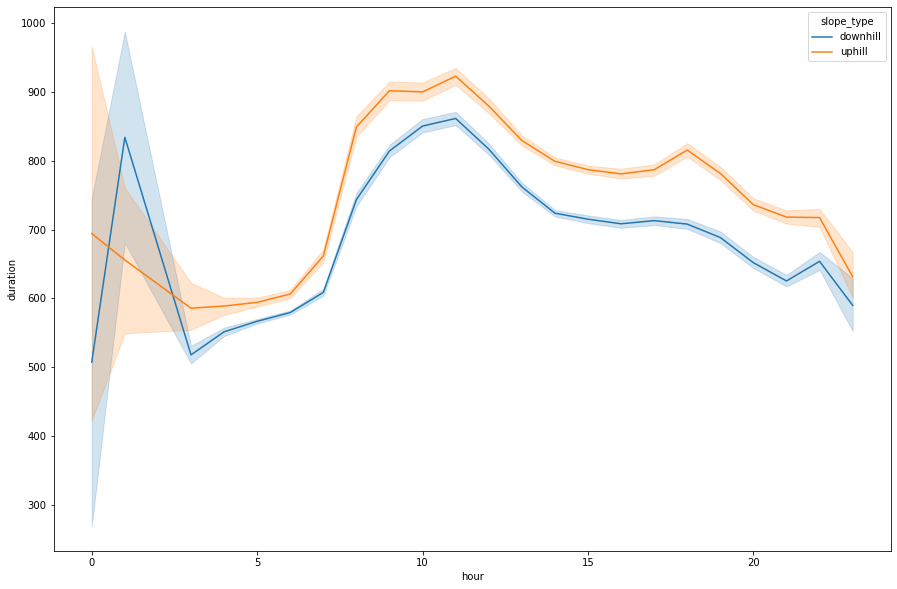

In [39]:
plt.figure(figsize=(15,10))
trips["hour"] = pd.to_datetime(trips["started_at"]).dt.hour
sns.lineplot(data=trips[trips['slope_type']!="flat"], x="hour", y="duration", hue="slope_type", estimator="mean")

Text(0.5, 1.0, 'Number of Trips by Weekday')

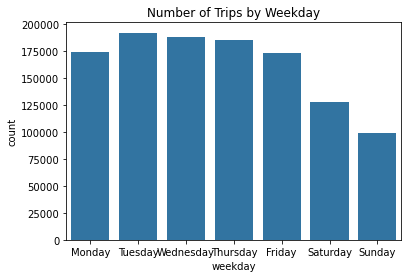

In [44]:
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
trips["weekday"] = pd.to_datetime(trips["started_at"]).dt.day_name()
sns.countplot(data=trips, x="weekday", order=weekday_order)
plt.title("Number of Trips by Weekday")

Most people assume weekends are peak for casual biking, but data shows otherwise. Turns out, weekday commuting is the real engine behind Bysykkel usage  — not leisure rides.

⸻  

Quick Summary :  
	•	Sunday = lowest ride count  
	•	Saturday = next lowest  
	•	Weekdays = consistently higher  
	•	Likely interpretation: Bysykkel is primarily a commuter tool, not just a weekend toy.  
  


Text(0.5, 1.0, 'Average Trip Duration by Weekday')

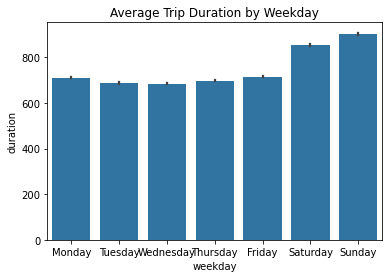

In [45]:
sns.barplot(data=trips, x="weekday", y="duration", order=weekday_order, estimator="mean")
plt.title("Average Trip Duration by Weekday")

Text(0.5, 1.0, 'Total Trip Duration by Weekday')

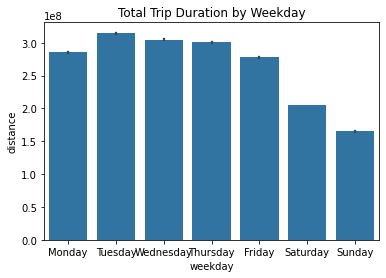

In [46]:
sns.barplot(data=trips, x="weekday", y="distance", order=weekday_order, estimator="sum")
plt.title("Total Trip Duration by Weekday")

🚴‍♂️ Weekends = fewer trips, but longer ones  
💼 Weekdays = more trips, but shorter  

What that suggests:  
	•	Weekdays: People are riding to work, school, or errands — short, practical, repeatable trips.  
	•	Weekends: People ride for leisure — longer joyrides, detours, exploration, maybe even group rides.  

#con.close()